## State Space Modeling of Team Strength Using Historical Score

This notebook contains the description and results of a model predicting score differences in English Premier League games using a State Space model. The English Premier League contains 20 teams, which play each other home and away. The team strengths of these teams are modeled over the course of a season using state space methods. Using team strengths predictions for score differences are made for each game.

## Preparing the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pystan

In order to get team strength ratings at the beginning of the season, points totals from the previous season are used. The points are normalized to a scale of (-1, 1), with the highest points scoring team getting a score of 1 and the lowest team getting -1. Since the bottom three teams are relegated and replaced by three promoted teams from the lower division, there are three teams in our dataset which are all given a score of -1.

The data used for the model is game by game results taken from http://www.football-data.co.uk/

This data is used to prepare a data dictionary that is fed to the stan model. This dictionary contains all the variables used by the model.

In [2]:
p = pd.read_csv('prevseason.csv', header = None)
max_s = max(p[1])
min_s = min(p[1])

p['score'] = 2*p[1]/(max_s - min_s) - (max_s + min_s)/(max_s - min_s)

In [3]:
def prepare_data(filename):
    
    f = pd.read_csv('E02017.csv', dayfirst = True)
    f = f[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'B365H', 'B365D', 'B365A']]
    f['p_home'] = (1/f['B365H'])     
    f['score_diff'] = f['FTHG'] - f['FTAG']
    
    data_dict = {}
    Teams = []
    data_dict['teams'] = list(f['HomeTeam'].unique())
    
    for i in data_dict['teams']:
        Teams.append(i)
        
    data_dict['nteams'] = f['HomeTeam'].nunique()
    data_dict['ngames'] = len(f['score_diff'])
    data_dict['nweeks'] = int(np.floor(2*data_dict['ngames']/data_dict['nteams']))
    
    for g in range(0, data_dict['ngames'] ):
        f.loc[g, 'home_week'] = sum(f.loc[0:g, 'HomeTeam'] == f.loc[g, 'HomeTeam']) + \
                                sum(f.loc[0:g, 'AwayTeam'] == f.loc[g, 'HomeTeam'])   
        f.loc[g, 'away_week'] = sum(f.loc[0:g, 'AwayTeam'] == f.loc[g, 'AwayTeam']) + \
                                sum(f.loc[0:g, 'HomeTeam'] == f.loc[g, 'AwayTeam']) 
    
    data_dict['home_week'] = f['home_week'].astype('int')
    data_dict['away_week'] = f['away_week'].astype('int')
    
    data_dict['home_team'] = []
    data_dict['away_team'] = []
    data_dict['score_diff'] = []
    
    for g in range(0, data_dict['ngames'] ):
        data_dict['home_team'].append(1 + Teams.index(f.loc[g, 'HomeTeam']))
        data_dict['away_team'].append(1 + Teams.index(f.loc[g, 'AwayTeam']))
        data_dict['score_diff'].append(f.loc[g, 'score_diff'])
        
    data_dict['prev_strength'] = np.zeros(len(Teams))
    
    for i in range(len(p[0])):
        if p[0][i] in Teams:
            data_dict['prev_strength'][Teams.index(p[0][i])] = p.loc[i, 'score']
        else:
            data_dict['prev_strength'][i] = -1
        
    return f, data_dict, Teams

In [4]:
f, data_dict, Teams = prepare_data('E02017.csv')

## Description of the Stan model

The model takes in the following variables:

Number of teams (nteams)

Number of games (ngames)

Number of game weeks (nweeks)

Week number for the team playing at home (home_week)

Week number for the team playing away (away_week)

Base ratings for each team based on previous season's performance (prev_strength)

These variables are used to determine the team strength rating, which is then used to predict score differences.

The team strength rating for team i in week w is modeled as a Gaussian random walk. 
$$ a_{w, i} \sim N(a_{w-1, i}, \sigma_{a,i}) $$

The team strength rating for week 1 is taken using the previous season's points total and modeled as:
$$ a_{1, i} \sim N(prevcoef * a_{0, i}, \sigma_{a0}) $$

Using this rating we model score difference in game j as follows:
$
y_{j} \sim studentt(\nu, a_{homeweek(i), hometeam(i)} - a_{awayweek(i), awayteam(i)} + b_{home}, \sigma_y)
$

\sigma_{a,j} models the week by week variance from team ability in the previous week. The prior for \sigma{a,i} is
$$ \sigma_{a,i} \sim N(0, \tau_{i}) \\
\tau_{i} \sim Cauchy(0, 1) $$

prevceof and $\sigma_{a0}$ are both given weakly informative priors of N(0,5)

In [5]:
model = """
data {
    int<lower=1> nteams;       // total number of teams
    int<lower=1> ngames;      // total number of games
    int<lower=1> nweeks;      // total number of weeks
    int<lower=1> home_week[ngames]; // week number for the home team 
    int<lower=1> away_week[ngames]; // week number for the away team
    int<lower=1, upper=nteams> home_team[ngames]; // home team ID
    int<lower=1, upper=nteams> away_team[ngames]; // away team ID
    vector[ngames] score_diff; // homegoals - awaygoals
    row_vector[nteams] prev_strength;
}

parameters {
    real prev_coef;
    real alpha; // baseline home strength
    real<lower=0> sigma_a0; // variance in team ability between seasons
    real<lower=0> tau_a; // game to game variation
    real<lower=1> nu; // t-dist degree of freedom
    real<lower=0> sigma_scorediff; // variance in score_diff
    row_vector<lower=0>[nteams] sigma_a_base; // game by game variation
    matrix[nweeks, nteams] eta_a; // random variation
}

transformed parameters {
    matrix[nweeks, nteams] a; // team abilities
    row_vector<lower=0>[nteams] sigma_a; //game by game variation
    a[1] = prev_coef * prev_strength + sigma_a0 * eta_a[1]; // initial abilities
    sigma_a = tau_a * sigma_a_base;
    for (w in 2: nweeks){
        a[w] = a[w-1] + sigma_a .* eta_a[w]; // evolution of abilities
    }
}
 
model { 
    vector[ngames] a_diff;
    
    // Priors
    nu ~ gamma(2, 0.2);
    prev_coef ~ normal(0, 1);
    sigma_a0 ~ normal(0,1);
    sigma_scorediff ~ normal(0,5);
    alpha ~ normal(0,0.2);
    sigma_a_base ~ normal(0,1);
    tau_a ~ cauchy(0,1);
    to_vector(eta_a) ~ normal(0,1);
    
    // Likelihood
    for (g in 1:ngames) {
        a_diff[g] = a[home_week[g], home_team[g]] - a[away_week[g], away_team[g]];
        
    }
    score_diff ~ student_t(nu, a_diff + alpha, sigma_scorediff);
}

generated quantities {
    vector[ngames] score_diff_rep;
    for (g in 1:ngames)
        score_diff_rep[g] = student_t_rng(nu, a[home_week[g], home_team[g]] - a[away_week[g], away_team[g]] + alpha, sigma_scorediff);
}
"""

## Fitting the model

The model is fit after every round of 10 games. So it is refit 38 teams. The samples after fitting the model each time are collected in the 3D matrix a_samps. These samples are then used to look at the parameter estimates later on.

In [6]:
a_samps = np.zeros((1500, data_dict['nweeks'], data_dict['nteams']))

for w in range(1, data_dict['nweeks'] + 1):
    
    data_w = {}
    idx = w*10
    data_w['nteams'] = data_dict['nteams']
    data_w['home_team'] = data_dict['home_team'][0:idx]
    data_w['away_team'] = data_dict['away_team'][0:idx]
    
    data_w['score_diff'] = data_dict['score_diff'][0:idx]
    data_w['home_week'] = data_dict['home_week'][0:idx]
    data_w['away_week'] = data_dict['away_week'][0:idx]
    
    data_w['ngames'] = w*10
    
    data_w['nweeks'] = max(list(data_w['home_week']) + list(data_w['away_week']))
    data_w['prev_strength'] = data_dict['prev_strength']
    
    fit = pystan.stan(model_code= model, data=data_w, iter=750, warmup = 375, chains=4, n_jobs = 4)
    
    samples = fit.extract(permuted = True)
    
    for g in range((w-1)*10, w*10):
        
        a_samps[:, data_dict['home_week'][g]-1, data_dict['home_team'][g]-1] = samples['a'][:, data_dict['home_week'][g]-1, data_dict['home_team'][g]-1]
        a_samps[:, data_dict['away_week'][g]-1, data_dict['away_team'][g]-1] = samples['a'][:, data_dict['away_week'][g]-1, data_dict['away_team'][g]-1]

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b5b78d65548580ef20038edb9a67bfe NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b5b78d65548580ef20038edb9a67bfe NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b5b78d65548580ef20038edb9a67bfe NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b5b78d65548580ef20038edb9a67bfe NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b5b78d65548580ef20038edb9a67bfe NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b5b78d65548580ef20038edb9a67bfe NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b5b78d65548580ef20038edb9a67bfe NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b5b78d65548580ef20038edb9a67bfe NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b5b78d65548580ef20038edb9a67bfe NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b5b78d65548580ef20038edb9a67bfe NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b5b

In [7]:
## looking at the parameter estimates
print(fit)

Inference for Stan model: anon_model_7b5b78d65548580ef20038edb9a67bfe.
4 chains, each with iter=750; warmup=375; thin=1; 
post-warmup draws per chain=375, total post-warmup draws=1500.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
prev_coef            -0.09    0.02   0.38  -0.88  -0.32  -0.08   0.16   0.68    478    1.0
alpha                 0.33  1.6e-3   0.08   0.18   0.28   0.33   0.38   0.48   2279    1.0
sigma_a0              0.76  8.5e-3   0.15   0.51   0.65   0.74   0.84   1.12    325   1.01
tau_a                 0.05  2.1e-3   0.04 2.1e-3   0.02   0.04   0.07   0.15    379   1.01
nu                   16.36    0.16   6.74   7.35  11.55  14.92  19.58  33.08   1891    1.0
sigma_scorediff       1.48  1.7e-3   0.07   1.35   1.44   1.49   1.53   1.63   1799    1.0
sigma_a_base[1]       0.74    0.02    0.6   0.02   0.26    0.6   1.08   2.19   1573    1.0
sigma_a_base[2]       0.75    0.01   0.59   0.03   0.28    0.6   1.07   2.16   1797   

## Looking at the Results of the model

The charts below show the estimated team strength ratings for all 20 teams along with their 50% and 95% confidence intervals.

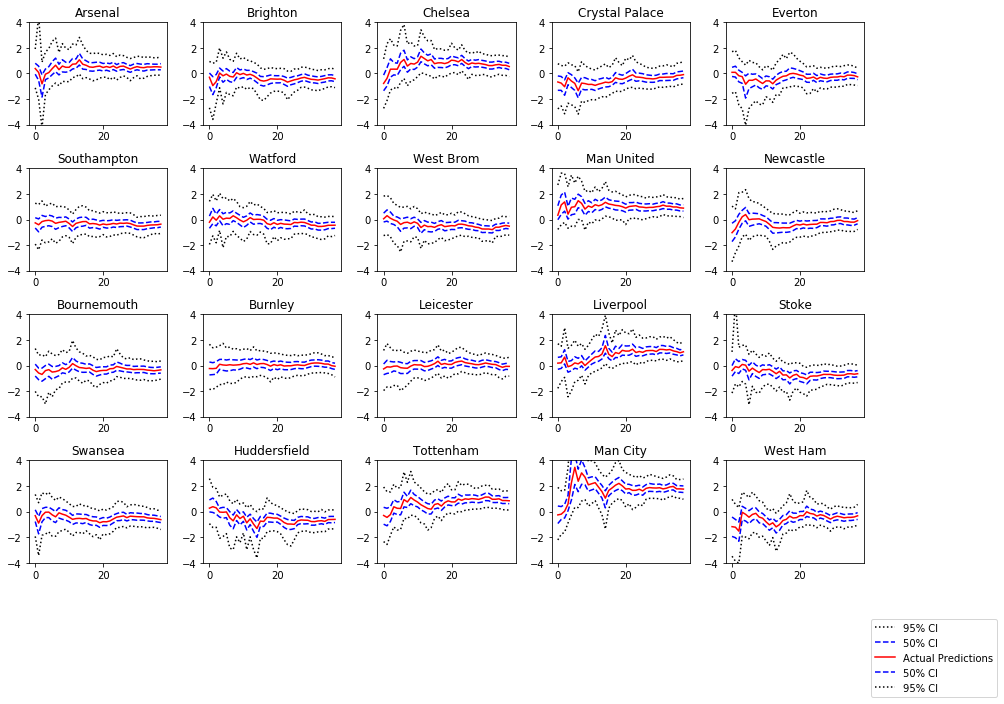

In [116]:
plt.figure(figsize = (14,10))
for i in range(0, 20):
    plt.subplot(4,5,i+1)
    fit_1 = np.percentile(a_samps[:, :, i], q = [2.5, 25, 50, 75, 97.5], axis = 0)

    l1, = plt.plot(range(fit_1.shape[1]), fit_1[0], 'k:', label = '95% CI')
    l2,  = plt.plot(range(fit_1.shape[1]), fit_1[1], 'b--', label = '50% CI')
    l3, = plt.plot(range(fit_1.shape[1]), fit_1[2], 'r-', label = 'Predicted Strength')
    l4, = plt.plot(range(fit_1.shape[1]), fit_1[3], 'b--', label = '50% CI')
    l5, = plt.plot(range(fit_1.shape[1]), fit_1[4], 'k:', label = '95% CI')
    plt.ylim(-4, 4)
    plt.title(f'{Teams[i]}')

plt.legend([l1, l2, l3, l4, l5],['95% CI', '50% CI', 'Actual Predictions', '50% CI', '95% CI'],loc = 'upper right',bbox_to_anchor=(2, -0.5))
plt.tight_layout()

## Looking at the estimated team ability after 38 games

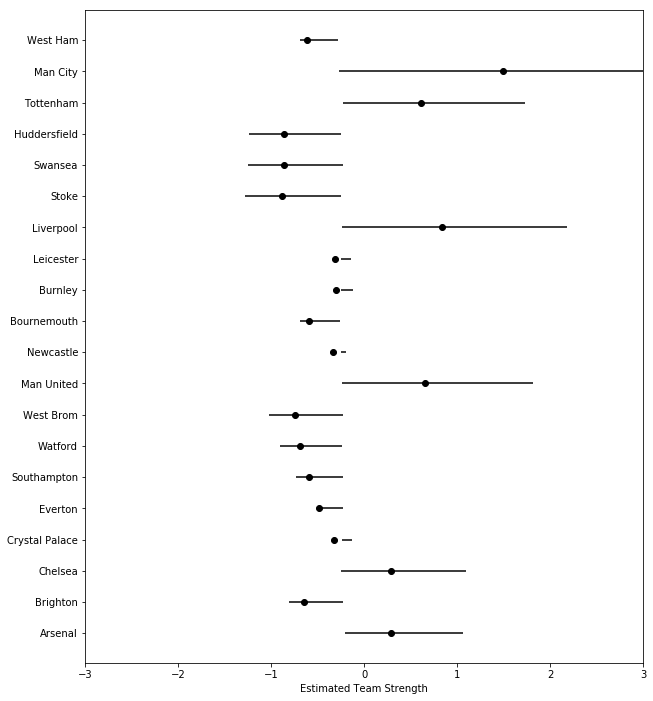

In [85]:
fit_final = np.percentile(a_samps[:, 37, 0:20], q = [25, 50, 75], axis = 0)
x = fit_final[0]
y = np.linspace(-3, 3, len(Teams))
my_yticks = Teams
plt.figure(figsize = (10,12))
plt.yticks(y, my_yticks)
plt.errorbar(x,y, xerr = [list(fit_final[1]), list(fit_final[2])], fmt = 'ko')
#plt.xlabel('Estimated Home Advantage (log-odds scale)')
plt.xlim(-3,3)
plt.xlabel('Estimated Team Strength')
plt.show()
    

## Looking at the estimated team abilities after 19 games (Half the season)

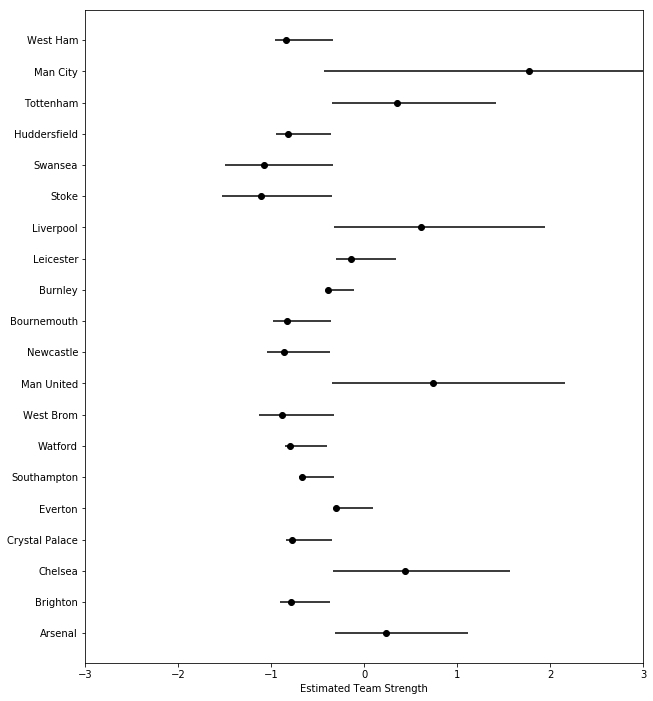

In [84]:
fit_init = np.percentile(a_samps[:, 18, 0:20], q = [25, 50, 75], axis = 0)
x = fit_init[0]
y = np.linspace(-3, 3, len(Teams))
my_yticks = Teams
plt.figure(figsize = (10,12))
plt.yticks(y, my_yticks)
plt.errorbar(x,y, xerr = [list(fit_init[1]), list(fit_init[2])], fmt = 'ko')
plt.xlabel('Estimated Team Strength')
plt.xlim(-3,3)
plt.show()

In [86]:
samples.keys()

odict_keys(['prev_coef', 'alpha', 'sigma_a0', 'tau_a', 'nu', 'sigma_scorediff', 'sigma_a_base', 'eta_a', 'a', 'sigma_a', 'score_diff_rep', 'lp__'])

In [87]:
samples['score_diff_rep'].shape

(1500, 380)

## Evaluating how well calibrated our model is

The chart below shows the predicted score differences for all 380 games, along with 50% and 95% confidence intervals.

The red dots show the actual score differences. As you can see most of the actual scores lie well within the 50% confidence interval.

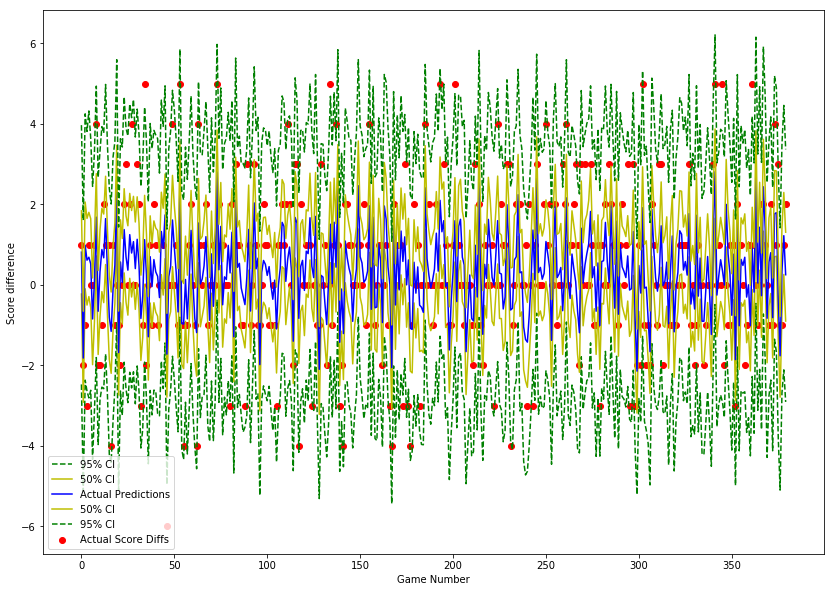

In [119]:
pred_scores = np.percentile(samples['score_diff_rep'], q = [2.5, 25, 50, 75, 97.5], axis = 0)

plt.figure(figsize = (14,10))
r1, = plt.plot(range(pred_scores.shape[1]),pred_scores[0], 'g--', label = '95% CI')
r2, = plt.plot(range(pred_scores.shape[1]),pred_scores[1], 'y-', label = '50% CI')
r3, = plt.plot(range(pred_scores.shape[1]),pred_scores[2], 'b-', label = 'predicted score diffs')
r4, = plt.plot(range(pred_scores.shape[1]),pred_scores[3], 'y-')
r5, = plt.plot(range(pred_scores.shape[1]),pred_scores[4], 'g--')
r6 = plt.scatter(range(pred_scores.shape[1]), data_dict['score_diff'], c = 'r')
plt.xlabel('Game Number')
plt.ylabel('Score difference')
plt.legend([r1, r2, r3, r4, r5, r6], ['95% CI', '50% CI', 'Actual Predictions', '50% CI', '95% CI', 'Actual Score Diffs'], loc = 'lower left')